# Implied Probability via Butterfly Spreads

Using butterfly spreads to approximate the risk-neutral pdf of an asset.

### Resources Used
*Options, Futures, and Other Derivatives* - John C. Hull

*Option Pricing and Volatility* - Sheldon Natenberg

[*How Options Implied Probabilities Are Calculated*](https://www.morganstanley.com/content/dam/msdotcom/en/assets/pdfs/Options_Probabilities_Exhibit_Link.pdf) - Morgan Stanley Research

### Building a butterfly

A butterfly consists of options at three equally-spaced strike prices with a short position at the middle strike and long positions on the outer strikes (all with the same maturity). The ratio of contracts should be 1:2:1 and this can be done with calls or puts.

In [295]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm

Let's check out how this works by adding the options to the position one at a time.

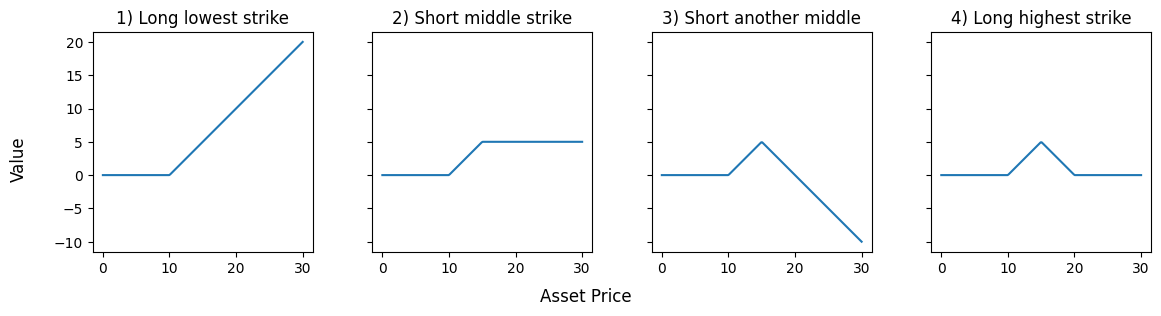

In [296]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 3))
x = np.linspace(0,30,200)

titles = ['1) Long lowest strike', '2) Short middle strike', '3) Short another middle', '4) Long highest strike']

y0 = np.maximum(x-10,0)
y1 = y0 - np.maximum(x-15,0)
y2 = y1 - np.maximum(x-15,0)
y3 = y2 + np.maximum(x-20,0)
y = [y0, y1, y2, y3]

ax[0].set_aspect('equal', share=True)
for i in range(4):
    ax[i].set_title(titles[i])
    ax[i].plot(x, y[i])

fig.supxlabel("Asset Price")
fig.supylabel("Value")
fig.tight_layout();

It works the same way with puts:

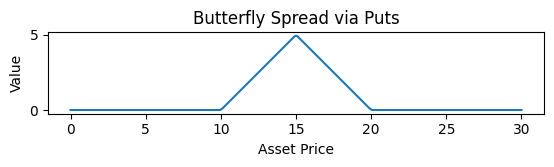

In [297]:
x = np.linspace(0,30,200)
y = np.maximum(10-x,0) - 2 * np.maximum(15-x,0) + np.maximum(20-x,0)  # All positions together

plt.gca().set_aspect('equal')
plt.title('Butterfly Spread via Puts')
plt.ylabel('Value')
plt.xlabel('Asset Price')
plt.plot(x,y);

### Probabilities from Butterflies

Let's call our middle strike $K$ and the spread to the next strike $\delta$. This means we have options at strikes $K - \delta$, $K$, and $K + \delta$. How can we get a probability from this position? Instead, let's think about how we would go about pricing this butterfly if we could not just look it up. 

Let's think about the butterfly above with strikes at 10, 15, and 20. We need the value of the butterfly given that we are between 10 and 20 as well as the probability (p) that we are between those strikes. Given that $\delta$ is small, we can assume p is the same across the entire $2\delta$ spread. 

Given that we are between 10 and 15, the value of the butterfly is simply the area under the triangle. So, $0.5 \times base \times height$. That will be $0.5 \times 2\delta \times \delta$ or just $\delta^{2}$.

Now we have: 
$$butterfly = p \times \delta^{2}$$

If we know how much the butterfly costs, we can back out p! Almost. The right hand side is the value at expiration, and since options generally have a stock-type settlement (meaning options are paid for upfront), we have to discount this.

So finally we have:
$$butterfly = e^{-rT}\times p \times \delta^{2} \quad \implies \quad p = e^{rT} \frac{butterfly}{\delta^{2}}$$

If we repeat this process for a bunch of overlapping butterflies, we can find the entire (approximated) risk-neutral pdf of a given asset. Before doing this with real data, let's check it out with prices from the Black-Scholes model. This way we can check if we can get a good approximation of the log-normal prices that the Black-Scholes model assumes.

In [298]:
def butterfly(S0, K, sigma, r, T, delta, d=0):
    #Compute the cost of a butterfly given the underlying characteristics, K, and delta
    strikes = [K-delta, K, K+delta]
    calls = []
    
    for strike in strikes:
        d1 = (math.log(S0 / strike) + (r - d + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        price = S0 * norm.cdf(d1) * math.exp(-d * T) - strike * math.exp(-r * T) * norm.cdf(d2)
        calls.append(float(price))
    
    return round(calls[0] - 2 * calls[1] + calls[2], 5)  # Long K - delta, short 2 K, long K + delta

def calc_prob(S0, K_start, K_stop, sigma, r, T, delta):
    """
    Calculate the butterfly price and implied probability centered at K from K_start to K_stop incrementing by delta
    Note that (K_start - delta) should be greater than 0
    """
    prob_dict = {'strike':[], 'butterfly':[], 'probability':[]}
    K_range = np.linspace(K_start, K_stop, int((K_stop - K_start)/delta) + 1)
    
    for K in K_range:
        prob_dict['strike'].append(K)
        bfly = butterfly(S0, K, sigma, r, T, delta)
        prob_dict['butterfly'].append(bfly)
        prob = np.exp(r * T) * (bfly / (delta ** 2))
        prob_dict['probability'].append(prob)
        
    return pd.DataFrame(prob_dict)

In [299]:
S0 = 100
K_start = 1
K_stop = 200
sigma = 0.2
r = 0.06
T = 0.5
delta = 0.5

prob_df = calc_prob(S0,K_start,K_stop,sigma,r,T,delta)
prob_df.iloc[198:208,:]

,strike,butterfly,probability
198,100.0,0.00678,0.027946
199,100.5,0.00677,0.027905
200,101.0,0.00676,0.027863
201,101.5,0.00674,0.027781
202,102.0,0.00671,0.027657
203,102.5,0.00667,0.027493
204,103.0,0.00663,0.027328
205,103.5,0.00658,0.027122
206,104.0,0.00652,0.026874
207,104.5,0.00645,0.026586


This output seems reasonable. The butterflies are super cheap since in this example it would be a bet that the underlying falls within a $1 range. 
Let's check out the pdf:

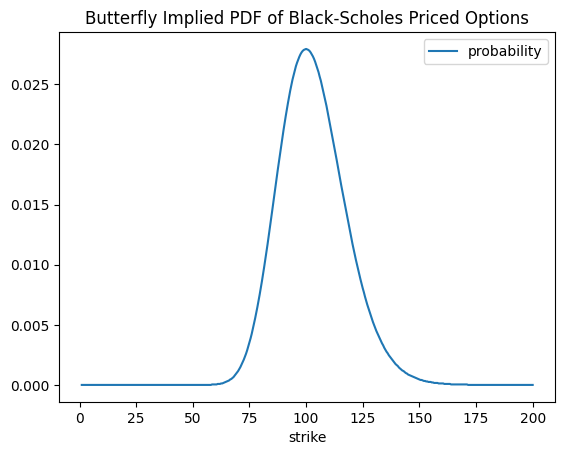

In [300]:
prob_df.plot('strike', 'probability', title='Butterfly Implied PDF of Black-Scholes Priced Options');

It looks log-normal which is great, but let's compare it to the exact distribution we would expect with the Black-Scholes model. 

$$\mu = \ln(S_0) + \left( r - \frac{\sigma^2}{2} \right) T$$
$$\sigma_{\text{ln}} = \sigma \sqrt{T}$$


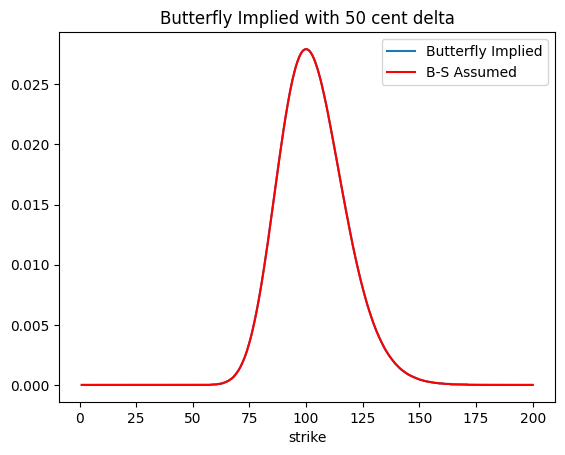

In [301]:
x = np.linspace(K_start, K_stop, int((K_stop - K_start)/delta) + 1)
mu = np.log(S0) + (r - ((sigma**2)/2)) * T
log_sigma = np.sqrt(T) * sigma
p = lognorm.pdf(x = x, scale = np.exp(mu), s = log_sigma)
prob_df.plot('strike', 'probability')
plt.title('Butterfly Implied with 50 cent delta')
plt.plot(x, p, 'r')
plt.legend(['Butterfly Implied', 'B-S Assumed']);

Perfect! For doing this with the actual price of a butterfly things will be more complicated as we will have to have a larger delta and the range of options that are actively traded will be much smaller.

Let's see what happens with larger deltas:

In [302]:
delta_dict = {}
for i in [5,10,20]:
    delta_dict[i] = calc_prob(S0,i*2,K_stop,sigma,r,T,i)

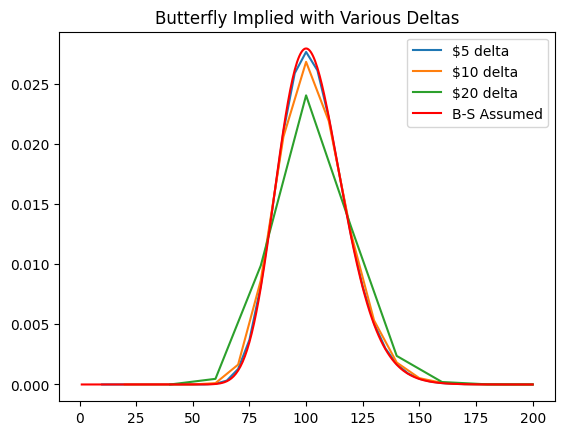

In [303]:
x = np.linspace(K_start, K_stop, int((K_stop - K_start)/delta) + 1)
mu = np.log(S0) + (r - ((sigma**2)/2)) * T
log_sigma = np.sqrt(T) * sigma
p = lognorm.pdf(x = x, scale = np.exp(mu), s = log_sigma)
for i in [5,10,20]:
    plt.plot(delta_dict[i].strike, delta_dict[i].probability)
plt.title('Butterfly Implied with Various Deltas')
plt.plot(x, p, 'r')
plt.legend(['$5 delta', '$10 delta', '$20 delta', 'B-S Assumed']);

### Real Options Data
As mentioned this will be much more difficult because some of the options will have very small trading volumes. So instead of using just calls, I will use calls and puts. 

Idea: if this doesn't work well consider looking at the vol skew and getting B-S prices from that (is this a bad idea?)

In [304]:
import yfinance as yf
tk = yf.Ticker('AAPL')
tk.options  # Available expiration dates

('2024-06-14',
 '2024-06-21',
 '2024-06-28',
 '2024-07-05',
 '2024-07-12',
 '2024-07-19',
 '2024-07-26',
 '2024-08-16',
 '2024-09-20',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

It is 2024-6-12, and I will look at the 2024-12-20 option which is a little over 6 months until expiration. Let's see what Apple is currently trading at and then the volume for calls and puts.

In [305]:
currentPrice = tk.info['currentPrice']
currentPrice

213.07

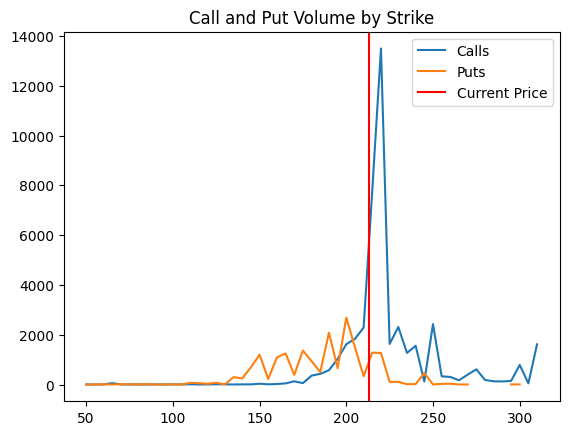

In [306]:
# tk.option_chain(tk.options[11]).calls.to_pickle('Data/AAPL_Calls_6122024.p')  # Saving
# tk.option_chain(tk.options[11]).puts.to_pickle('Data/AAPL_Puts_6122024.p')

call_df = pd.read_pickle('Data/AAPL_Calls_6122024.p')[['lastTradeDate', 'strike', 'bid', 'ask', 'volume']]
put_df = pd.read_pickle('Data/AAPL_Puts_6122024.p')[['lastTradeDate', 'strike', 'bid', 'ask', 'volume']]

plt.plot(call_df.strike, call_df.volume)
plt.plot(put_df.strike, put_df.volume)
plt.title("Call and Put Volume by Strike")
plt.axvline(x=currentPrice, color='r')
plt.legend(['Calls', 'Puts', 'Current Price']);

Here we can see that we will be better off using OTM options. So puts below the current price and calls above the current price. Additionally, we will likely not get a good estimate the deeper we go into one of the tails. Also notice how the volume on nice even numbers is much higher. First I will combine the dataframes with puts from 100 to 200 and calls from 195 to 300.

In [307]:
T = 134/252  # Approximate trading days until expiration over 252
delta = 5  # Spread from one strike to another

call_df['c2'] = (call_df['bid'] + call_df['ask']) / 2  # get midpoint between bid and ask
put_df['c2'] = (put_df['bid'] + put_df['ask']) / 2

C = call_df.query("strike == 210").c2.values[0]  # Use Put-Call Parity to get a reasonable rate
P = put_df.query("strike == 210").c2.values[0]
r = np.log((P + currentPrice - C)/210) / (-T)
r

0.05018611079217502

In [308]:
# filter to the strikes with higher volume
call_df = call_df.query("strike >= 195 and strike <= 300")
put_df = put_df.query("strike <= 200 and strike >= 100")

# Shift up and down to get price of higher and lower strike for butterfly
call_df['c1'] = call_df['c2'].shift(1)
call_df['c3'] = call_df['c2'].shift(-1)
call_df['fly'] = ((call_df['c1'] - 2 * call_df['c2'] + call_df['c3']) / (delta**2)) * np.exp(r * T)

put_df['c1'] = put_df['c2'].shift(1)
put_df['c3'] = put_df['c2'].shift(-1)
put_df['fly'] = ((put_df['c1'] - 2 * put_df['c2'] + put_df['c3']) / (delta**2)) * np.exp(r * T)

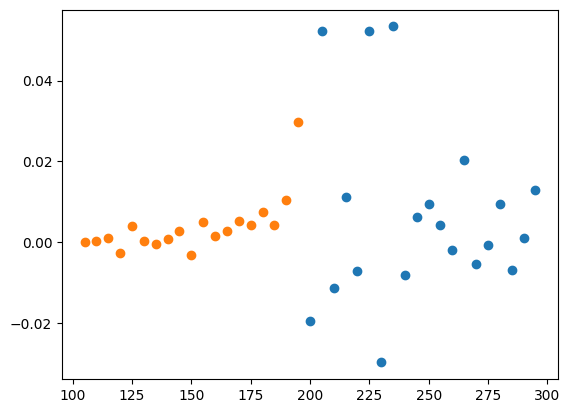

In [309]:
plt.scatter(call_df['strike'], call_df['fly'])
plt.scatter(put_df['strike'], put_df['fly']);